In [113]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Teste

In [114]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import numpy
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [132]:
def read_images(path, image_size):
  names = []
  training_images, training_labels = [], []
  label = 0
  for dirname, subdirnames, filenames in os.walk(path):
    for subdirname in subdirnames:
        names.append(subdirname)
        subject_path = os.path.join(dirname, subdirname)
        for filename in os.listdir(subject_path):
          img = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)
          if img is None:
            # The file cannot be loaded as an image.
            # Skip it.
            continue
          img = cv2.resize(img, image_size)
          training_images.append(img)
          training_labels.append(label)
        label += 1
  training_images = numpy.asarray(training_images, numpy.uint8)
  training_labels = numpy.asarray(training_labels, numpy.int32)
  #print(training_images.shape)
  return names, training_images, training_labels

In [180]:
path_to_training_images = '/content/gdrive/MyDrive/Dataset'
training_image_size = (470, 620)
names, training_images, training_labels = read_images(path_to_training_images, training_image_size)

In [181]:
print(names , training_labels)

['Joao Luiz', 'maria luiza', 'Vinicius'] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]


In [182]:
model = cv2.face.EigenFaceRecognizer_create()
model.train(training_images, training_labels)

<class 'numpy.ndarray'>
(620, 470)
['Joao Luiz', 'maria luiza', 'Vinicius']


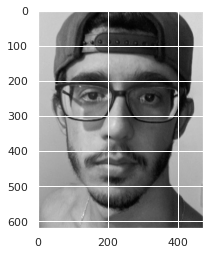

In [183]:
plt.imshow(training_images[13], cmap='gray')
print(type(training_images[0]))
print(training_images[0].shape)
print(names)

In [184]:
#nsamples, nx, ny = train_dataset.shape
#d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))
nsamples_i, nx_i, ny_i = training_images.shape
d2_training_images = training_images.reshape((nsamples_i, nx_i*ny_i))

(49, 291400)
(49, 15)


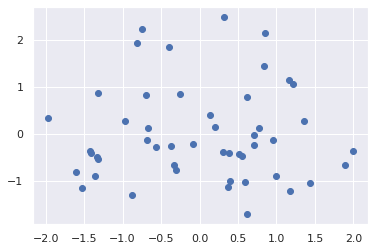

In [185]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=2)

pca = PCA(n_components=15, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

print(d2_training_images.shape)
pca_images = pca.fit_transform(d2_training_images)
print(pca_images.shape)
plt.scatter(pca_images[:,0], pca_images[:,1])

In [186]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(training_images, training_labels, random_state=10)

In [187]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(pca_images, training_labels)
print(grid.best_params_)

CPU times: user 224 ms, sys: 513 µs, total: 225 ms
Wall time: 224 ms
{'svc__C': 10, 'svc__gamma': 0.001}


In [188]:
training_labels.size

49

In [189]:
model = grid.best_estimator_
yfit = model.predict(pca_images)
print(yfit)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 2 1 1 1 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 0 2 2 0 2]


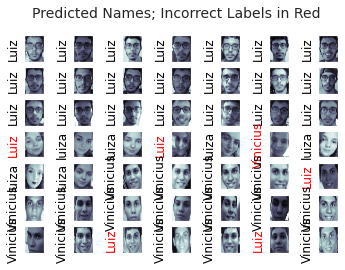

In [190]:
fig, ax = plt.subplots(7, 7)
for i, axi in enumerate(ax.flat):
    axi.imshow(training_images[i].reshape(620, 470), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(names[yfit[i]].split()[-1], color='black' if yfit[i] == training_labels[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [191]:
from sklearn.metrics import classification_report
print(classification_report(training_labels, yfit,target_names = names))

              precision    recall  f1-score   support

   Joao Luiz       0.81      1.00      0.89        21
 maria luiza       1.00      0.67      0.80         9
    Vinicius       0.94      0.84      0.89        19

    accuracy                           0.88        49
   macro avg       0.92      0.84      0.86        49
weighted avg       0.89      0.88      0.87        49

